# 課題4: プロ野球選手の年俸データのクラスタリング

ここでは、k-means法を利用したクラスタリングの理解を深めて頂くための課題を用意しました。Lesson6で使用したプロ野球選手の推定年俸のデータを使い、クラスタリングを行ってください。なお、クラスタリングはデータを正規化したうえで行ないます。

わからない場合は、ここまでのレッスン内容や各種ライブラリの公式ドキュメントを参照しましょう。

## 1. ライブラリのimport

In [1]:
# （変更しないでください）

# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# データの正規化
from sklearn.preprocessing import MinMaxScaler

# k-means法
from sklearn.cluster import KMeans

# シルエットプロット
from sklearn.metrics import silhouette_score, silhouette_samples

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

# seabornによる装飾を適用する
sns.set_theme()

## 2. データの読み込み

CSVファイル *baseball_salary.csv* を読み込み、dataset_baseに格納します。

In [2]:
# CSVファイルを読み込んでdataset_baseに格納する
dataset_base = pd.read_csv("baseball_salary.csv")


In [3]:
# dataset_baseの最初の5行を表示
print(dataset_base.head())


  球団   推定年俸   守備  年数  年齢   身長   体重  血液型  投打     年     打率   試合  打席数   打数   安打  \
0  c  21000  外野手  11  29  177   90  AB型  右左  2017  0.308  143  651  556  171   
1  c  19000  内野手   7  28  171   72   A型  右右  2017  0.271  138  629  565  153   
2  c  14000  内野手   5  29  171   85   A型  右左  2017  0.290  143  679  565  164   
3  c  11500  内野手   7  38  196  126   不明  右右  2017  0.265  116  405  344   91   
4  c  11000  内野手  20  41  189  102   B型  右右  2017  0.292  100  288  243   71   

   本塁打  打点  盗塁  四球  死球   三振  犠打  併殺打    出塁率    長打率    OPS  RC27  XR27   球団勝率  \
0   23  92  13  83   4  113   2    6  0.398  0.505  0.903  7.70  7.52  0.633   
1   14  56   8  32   1  107  30    9  0.311  0.405  0.716  4.10  4.01  0.633   
2    8  60  35  89  15  120   6    5  0.398  0.407  0.805  6.41  6.26  0.633   
3   27  78   0  50   8  111   0    8  0.368  0.532  0.900  6.80  6.90  0.633   
4    9  48   2  40   1   56   0    7  0.389  0.461  0.850  6.55  6.54  0.633   

   プレーオフ  球団平均得点   球団打率  
0      2    

In [4]:
# dataset_baseから「打率、打点」列を抜き出してdatasetに格納する
dataset = dataset_base[["打率", "打点"]].copy()


# 列名を、打率は「batting」、打点は「points」にリネームする
dataset.rename(columns={"打率": "batting", "打点": "points"}, inplace=True)


# datasetの先頭の5行を表示
print(dataset.head())


   batting  points
0    0.308      92
1    0.271      56
2    0.290      60
3    0.265      78
4    0.292      48


## 3. データの正規化

クラスタリングは類似度（距離）に基づいて行なわれるため、データの範囲に差がある場合は正規化を行ないます。

ここでは、Lesson5のデータの前処理で紹介した *Min-max normalization* を使ってみましょう。 `sklearn.preprocessing.MinMaxScaler()` を利用します。

参考：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [5]:
# MinMaxScalerで正規化を実施し、その結果を変数tempに格納する
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temp = scaler.fit_transform(dataset)

In [6]:
# 正規化後のデータの先頭の5行を表示
print(temp[:5])


[[0.616      0.87619048]
 [0.542      0.53333333]
 [0.58       0.57142857]
 [0.53       0.74285714]
 [0.584      0.45714286]]


In [7]:
# tempの0列目を「batting_scaled」、1列目を「points_scaled」という列名にして、datasetへ列として追加
dataset["batting_scaled"] = temp[:, 0]
dataset["points_scaled"] = temp[:, 1]

In [8]:
# 改めてdatasetの先頭の5行を表示
print(dataset.head())


   batting  points  batting_scaled  points_scaled
0    0.308      92           0.616       0.876190
1    0.271      56           0.542       0.533333
2    0.290      60           0.580       0.571429
3    0.265      78           0.530       0.742857
4    0.292      48           0.584       0.457143


## 4. データの可視化

Text(0, 0.5, 'Points (scaled)')

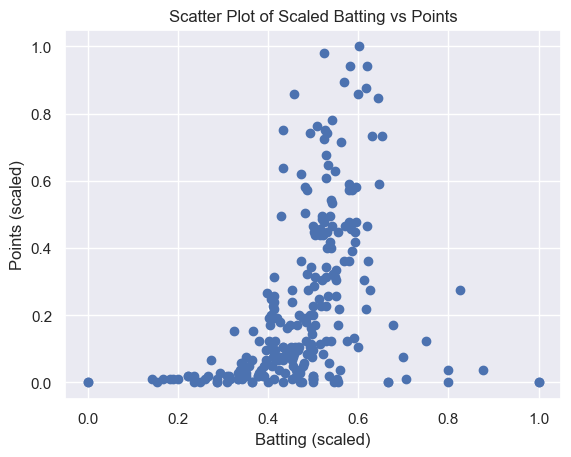

In [9]:
# 正規化後の打率と打点の散布図を描画する
plt.scatter(dataset["batting_scaled"], dataset["points_scaled"])

plt.title("Scatter Plot of Scaled Batting vs Points")
plt.xlabel("Batting (scaled)")
plt.ylabel("Points (scaled)")

## 5. クラスター数の決定

エルボーメソッドとシルエットプロットを使用してクラスター数を決定しましょう

### クラスタリングを行なうデータの抽出

In [10]:
# datasetからbatting_scaledとpoints_scaledを取り出して、numpy配列に変換してXに格納する
X = dataset[["batting_scaled", "points_scaled"]].to_numpy()


# Xの形状を確認
print(X.shape)


(241, 2)


### エルボーメソッド

In [11]:
# 最大クラスター数を10として、クラスター数1から10までのWCSS値を算出（変更しないでください）
wcss = []
c_list = np.arange(1, 11)

In [12]:
# クラスタ数の算出
sse = []
K = range(1, 10)  

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_) 

In [13]:
# WCSSの表示（変更しないでください）
wcss

[]

In [14]:
# エルボーメソッドのグラフの表示
sse = []

K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_) 

### シルエットプロット

In [15]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

In [16]:
# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
k = 3

model = KMeans(n_clusters=k, random_state=0)
model.fit(X)

labels = model.labels_

In [17]:
# シルエットスコアの平均値
silhouette_avg = silhouette_score(X, labels)
print("シルエットスコア（平均値）:", silhouette_avg)

# 各データのシルエットスコア
sample_silhouette_values = silhouette_samples(X, labels)
print("各データのシルエットスコア（先頭10件）:")
print(sample_silhouette_values[:10])

シルエットスコア（平均値）: 0.48949752782380296
各データのシルエットスコア（先頭10件）:
[0.65545716 0.41618692 0.19568835 0.64499843 0.64302286 0.66918012
 0.59320356 0.51670749 0.58994119 0.57753968]


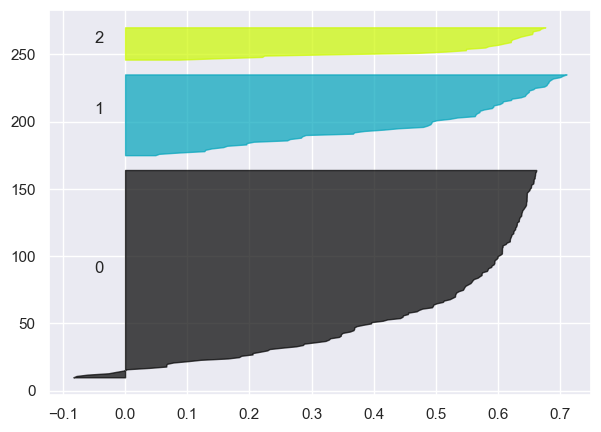

In [22]:
# シルエットプロットを描画
from matplotlib import cm

fig, ax = plt.subplots(figsize=(7, 5))
y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

## 6. 結果の確認

上記の結果をもとに、クラスタ数6で再度クラスタリングを実行し、分類ごとに色を分けて散布図にプロットしましょう。

In [23]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
model = KMeans(n_clusters=cluster_no, random_state=0)
labels = model.fit_predict(X)


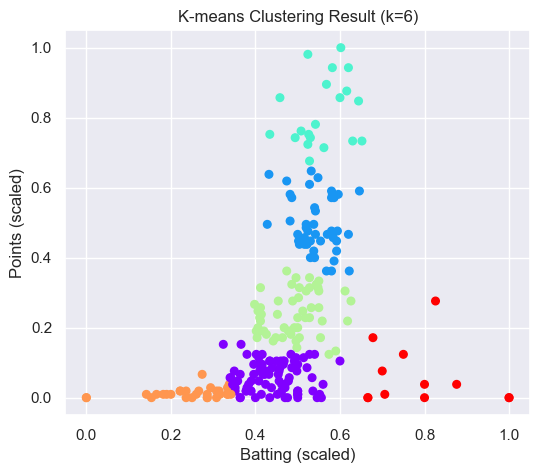

In [24]:
# k-means法によるクラスタリングの結果を描画
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow', s=30)
plt.title("K-means Clustering Result (k=6)")
plt.xlabel("Batting (scaled)")
plt.ylabel("Points (scaled)")
plt.grid(True)
plt.show()